In [1]:
import h5py

# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/mfunet-regularizedRMSE/mfunet-regularizedRMSE.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/mfunet-grayscale-01/epoch_19/mfunet_rmse.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/reg_mse_fix/reg_mse_fix_v3.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/lagrangian/lcnn-bugfix_v2/lcnn-bugfix.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/LUMIN/LUMIN-frozen.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/RainNet/RainNet-iterative.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/LUPIN-finetune/LUPIN-finetune.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/LUPIN-diff-pretrain/LUPIN-diff-pretrain.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/LUPIN-finetune-differenced/LUPIN-finetune-differenced-beta001.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/LUPIN-finetune-differenced/LUPIN-finetune-differenced-gauss_blur.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/LUPIN-diff-pretrain-rmse/LUPIN-diff-pretrain-rmse.h5', 'r')
# f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/LUPIN-diff-pretrain-rmse/LUPIN-diff-pretrain-rmse-nonnormalized.h5', 'r')
f = h5py.File('/data/softec-lagrangian-nowcasting/outputs/LUPIN-diff-finetune-rmse/LLUPIN-diff-pretrain-rmse-finetune.h5', 'r')

In [2]:
from datamodules import SHMUDataModule
from pathlib import Path
from utils.config import load_config

confpath = Path("") / "configs/LUPIN_differenced"
dsconf = load_config(confpath / "datasets.yaml")
modelconf = load_config(confpath / "model.yaml")

dsconf.SHMUDataset.transform_to_grayscale = True

datamodule = SHMUDataModule(dsconf, modelconf.train_params)
datamodule.setup("test")
dataset = datamodule.test_dataset

/opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pysteps configuration file found at: /opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/pysteps/pystepsrc



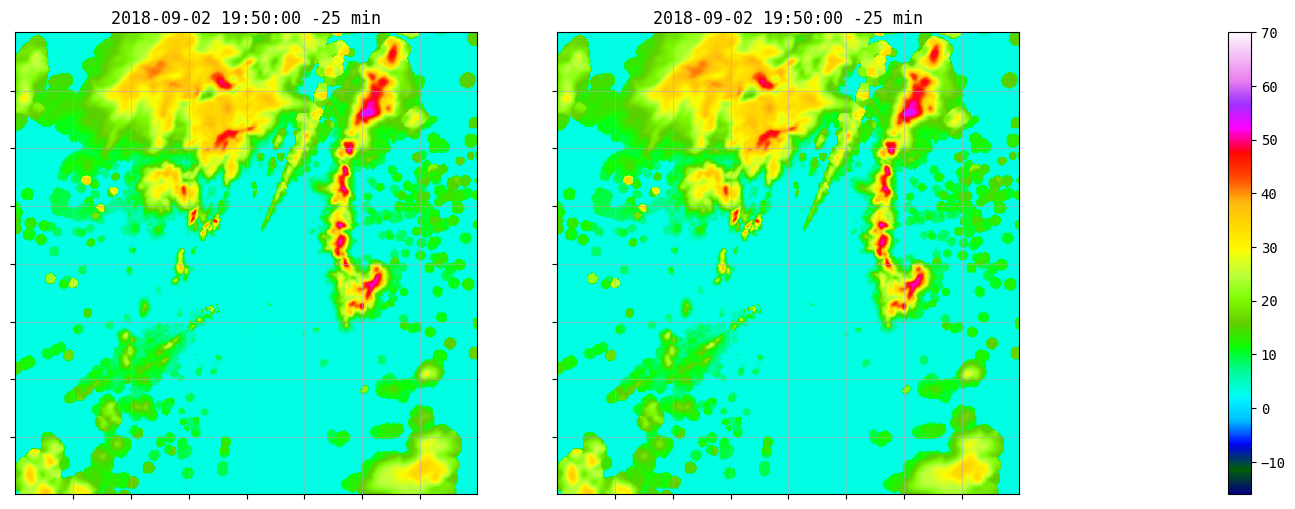

In [3]:
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
import numpy as np

plt.rcParams["font.family"] = "monospace"

sample_idx = random.randrange(len(dataset))
sample_idx = 40
sample_key = dataset.get_common_time(sample_idx).strftime("%Y-%m-%d %H:%M:%S")

x, y, idx = dataset[sample_idx]
arr = np.zeros((12, 336, 336))
y_arr = np.zeros((6, 336, 336))

for i in range(0, 6):
    arr[i] = np.array(dataset.from_transformed(x[i][0]))
    # arr[i][arr[i] < 10] = 0

for i in range(0, 6):
    arr[i+6] = np.array(f[sample_key]['model'][f'{i+1}']['data'])
    arr[i+6][arr[i+6] < 64] = 64
    arr[i+6] = arr[i+6] / 2 - 32
    # arr[i+6][arr[i+6] < 10] = 0 # L-CNN fix

for i in range(0, 6):
    y_arr[i] = np.array(dataset.from_transformed(y[i][0]))
    # y_arr[i][y_arr[i] < 10] = 0

fig, axes = plt.subplots(1, 3, width_ratios=[3,3,1], figsize=(16,6))

im = axes[1].imshow(arr[0], cmap='gist_ncar', vmin=-16, vmax=70)
axes[2].axis('off')
cbar = plt.colorbar(im, ax=axes[2])

def update(frame):
    axes[0].imshow(arr[frame], cmap='gist_ncar', vmin=-16, vmax=70)
    # axes[0].axis('off')
    axes[0].xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    axes[0].yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    axes[0].xaxis.set_ticklabels([])
    axes[0].yaxis.set_ticklabels([])
    axes[0].set_title(f"{sample_key}{(frame-5)*5:+4d} min")
    axes[0].grid(True, alpha=0.5)

    axes[1].imshow(arr[frame], cmap='gist_ncar', vmin=-16, vmax=70)
    # axes[1].axis('off')
    axes[1].xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    axes[1].yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    axes[1].xaxis.set_ticklabels([])
    axes[1].yaxis.set_ticklabels([])
    if frame >= 6:
        axes[1].imshow(y_arr[frame-6], cmap='gist_ncar', vmin=-16, vmax=70)
    axes[1].set_title(f"{sample_key}{(frame-5)*5:+4d} min")
    axes[1].grid(True, alpha=0.5)
    # plt.show()

ani = animate.FuncAnimation(fig=fig, func=update, frames=12)
HTML(ani.to_jshtml())

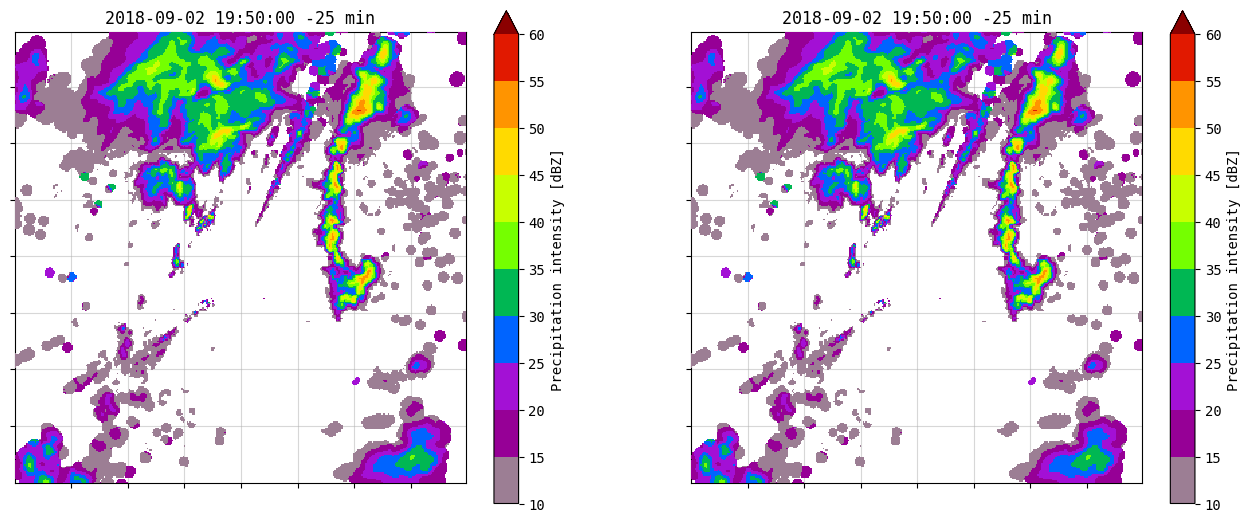

In [96]:
from pysteps.visualization import plot_precip_field

import random
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
import numpy as np

plt.rcParams["font.family"] = "monospace"

fig, axes = plt.subplots(1, 2, figsize=(16,8))

plot_precip_field(arr[0], colorbar=True, units='dBZ', ax=axes[0])
plot_precip_field(arr[0], colorbar=True, units='dBZ', ax=axes[1])

def update(frame):
    axes[0].clear()
    plot_precip_field(arr[frame], colorbar=False, units='dBZ', ax=axes[0])
    # axes[0].axis('off')
    axes[0].xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    axes[0].yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    axes[0].xaxis.set_ticklabels([])
    axes[0].yaxis.set_ticklabels([])
    axes[0].set_title(f"{sample_key}{(frame-5)*5:+4d} min")
    axes[0].grid(True, alpha=0.5)

    axes[1].clear()
    if frame < 6:
        plot_precip_field(arr[frame], colorbar=False, units='dBZ', ax=axes[1])
    if frame >= 6:
        plot_precip_field(y_arr[frame-6], colorbar=False, units='dBZ', ax=axes[1])
    axes[1].xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    axes[1].yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    axes[1].xaxis.set_ticklabels([])
    axes[1].yaxis.set_ticklabels([])
    axes[1].set_title(f"{sample_key}{(frame-5)*5:+4d} min")
    axes[1].grid(True, alpha=0.5)
    # plt.show()

ani = animate.FuncAnimation(fig=fig, func=update, frames=12)
HTML(ani.to_jshtml())